# Fiber Scatter
The purpose of this notebook is to investigate the scatter in flux across a plate

In [1]:
%matplotlib inline
import numpy as np
import os, sys, glob, fnmatch
import matplotlib.pyplot as plt
from astropy.io import fits
import matplotlib.cm as cm
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.integrate import trapz
import scipy.integrate as integrate
from scipy.linalg import lstsq

In [2]:
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u

In [3]:
from matplotlib.font_manager import FontProperties
font = FontProperties()
font.set_family('serif')
font.set_size('large')

In [4]:
DATA_DIR = '/Volumes/PFagrelius_Backup/sky_data/sky_flux/'

In [5]:
MetaData = np.load('/Users/parkerf/Research/SkyModel/BOSS_Sky/Analysis/MetaData/good_meta_rich.npy')

### Working with plate 4602

I took a QA document (spDiag2d) for a random plate/image:
- Plate: 4602 
- Image: 128408 
- MJD: 55644

In [6]:
data = np.load(DATA_DIR+'4602_calibrated_sky.npy')
plate_meta = MetaData[MetaData['PLATE'] == 4602]
meta = plate_meta[plate_meta['IMG'] == 128408]
np.unique(meta['MJD'])

array([ 55644.])

In [7]:
print(data.shape)

(960,)


In [11]:
blue_specno = np.random.choice(meta[meta['CAMERAS'] == b'b1']['SPECNO'],1)[0]
red_specno = np.random.choice(meta[meta['CAMERAS'] == b'r1']['SPECNO'],1)[0]

## Fit Lines

In [8]:
def gauss(x, *p):
    A, mu, sigma, B = p
    return A*np.exp(-(x-mu)**2/(2*sigma**2)) + B

In [9]:
qa_lines = [435.95, 557.89, 734.3, 888.83]

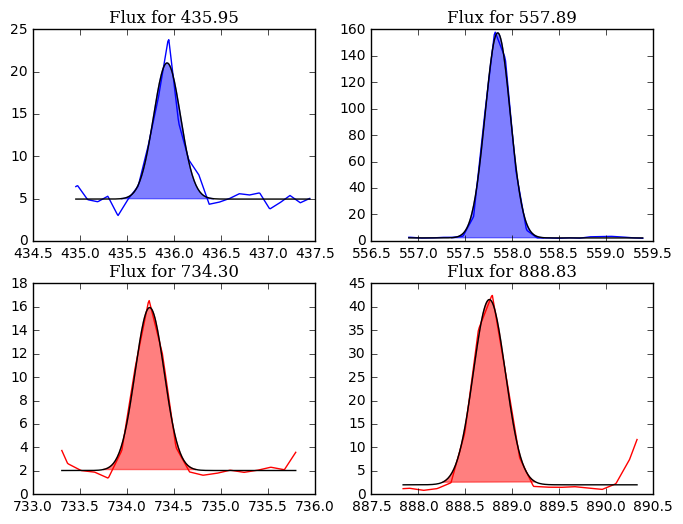

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (8,6))
ax = axes.ravel()
for i, line_w in enumerate(qa_lines):
    if line_w < 630:
        xx,dx = np.linspace(370, 630, (630-370)*100, retstep=True) 
        spectrum = data[blue_specno]
        c = 'b'
    elif line_w > 630:
        xx,dx = np.linspace(565, 1040, (1040-565)*100,retstep=True)
        spectrum = data[red_specno]
        c = 'r'
        
    f = interp1d(spectrum['WAVE'], spectrum['SKY'],bounds_error=False, fill_value=0)
    sky = f(xx)
    segment = np.where((xx>line_w-1.0)&(xx<line_w+1.5))
    wave_segment = xx[segment]
    sky_segment = sky[segment]
    
    p0 = [20., line_w, 1., 2.]
    popt,pcov = curve_fit(gauss,wave_segment,sky_segment,p0=p0)
    limits1 = np.where((wave_segment>(popt[1]-.5))&(wave_segment<(popt[1]+.5)))
   
    ax[i].plot(wave_segment, sky_segment, color = c,label = 'data')
    ax[i].plot(wave_segment, gauss(wave_segment, *popt), color = 'k', label = 'fit')
    ax[i].fill(wave_segment[limits1], gauss(wave_segment[limits1], *popt), color = c,alpha = 0.5)
    ax[i].set_title("Flux for %.2f" % line_w, fontproperties=font)

In [13]:
def cont_line(wave, level):
    line = np.ones(len(wave))
    return line*level

In [14]:
def line_flux_calc(line_w, wave, sky_spectrum):
    if line_w < 630:
        xx, dx = np.linspace(370, 630, (630-370)*100, retstep=True) 
    elif line_w > 630:
        xx, dx = np.linspace(565, 1040, (1040-565)*100,retstep=True)
    f = interp1d(wave, sky_spectrum, bounds_error=False, fill_value=0)
    sky = f(xx)
    segment = np.where((xx>line_w-5.)&(xx<line_w+5.))
    wave_segment = xx[segment]
    sky_segment = sky[segment]
    
    #error
    poisson = np.sqrt(sky_segment)
    
    p0 = [20., line_w, 1., 2.]
    popt,pcov = curve_fit(gauss,wave_segment,sky_segment,p0=p0)
    #limits = np.where((wave_segment>(popt[1]-.5))&(wave_segment<(popt[1]+.5)))
    #line_flux = trapz(gauss(wave_segment[limits],*popt),wave_segment[limits])
    #total_flux = np.sum(gauss(wave_segement, *popt))
    #cont_flux = np.sum(cont_line(wave_segment, popt[3]))
    #line_flux = (total_flux - cont_flux)*dx
    line_flux = integrate.quad(lambda x: gauss(x, *popt),(popt[1]-.5),(popt[1]+.5))[0]

    return line_flux, poisson

In [15]:
def double_plot(line_w, fib, i, wave, sky):
    if line_w < 630:
        xx, dx = np.linspace(370, 630, (630-370)*100, retstep=True) 
    elif line_w > 630:
        xx, dx = np.linspace(565, 1040, (1040-565)*100,retstep=True)
        
    flux, poisson = line_flux_calc(line_w, wave, sky)
    if flux > 0:
        fluxes.append(flux)
    
    f = interp1d(wave, sky, bounds_error=False, fill_value=0)
    sky = f(xx)
    segment = np.where((xx>line_w-1.)&(xx<line_w+20.))
    wave_segment = xx[segment]
    sky_segment = sky[segment]
    
    p0 = [20., line_w, 1., 2.]
    popt,pcov = curve_fit(gauss,wave_segment,sky_segment,p0=p0)
    pop1 = [popt[0], popt[1]+(i*0.5), popt[2],popt[3]]
    new_gauss = gauss(wave_segment, *pop1)
       
    ax1.plot(wave_segment, new_gauss, label = fib)
    ax1.text(pop1[1],pop1[0],fib)
    ax2.plot(fib, flux,'bx')
    
    return poisson

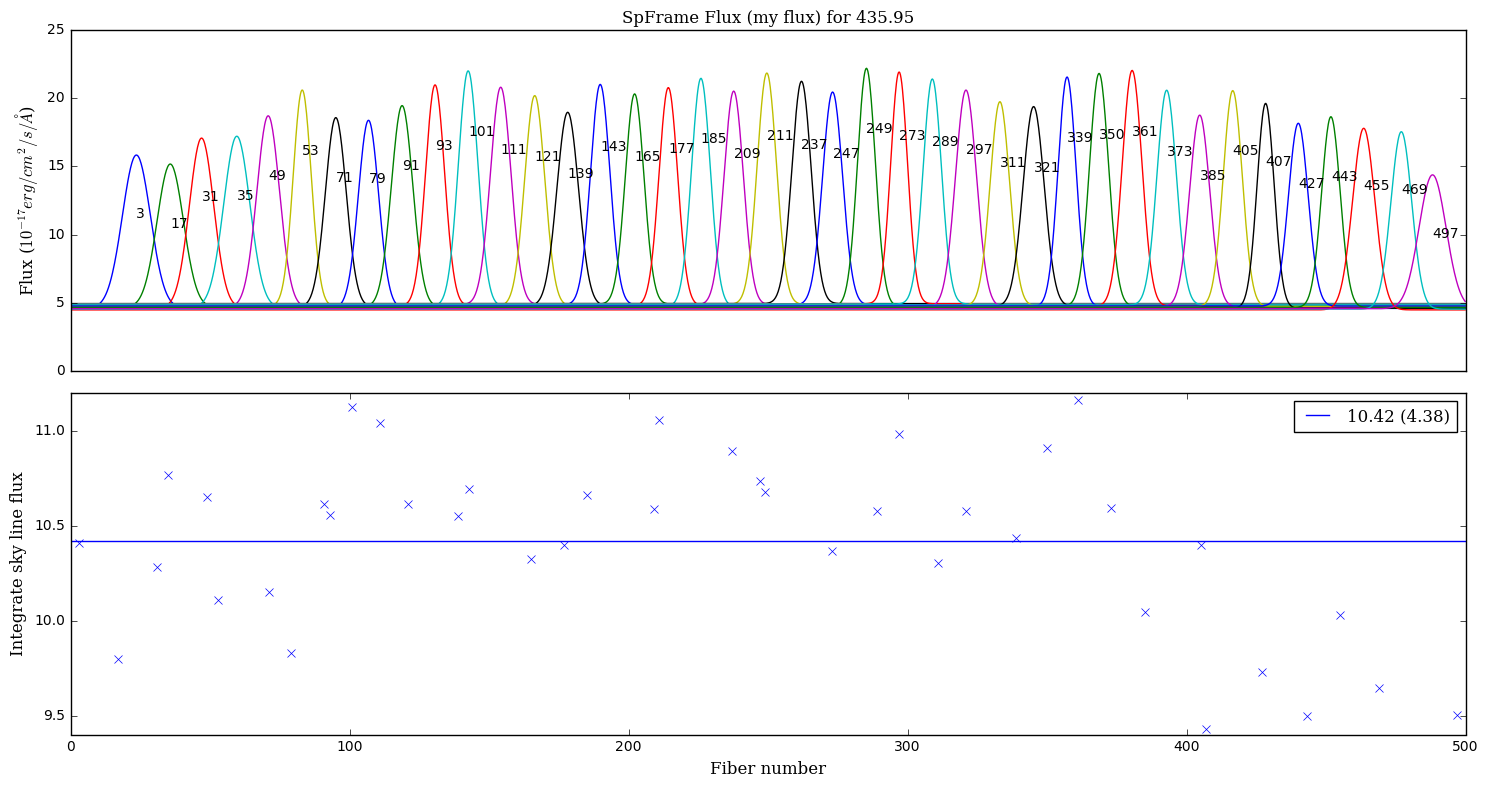

In [16]:
line_w = 435.95
fig, (ax1, ax2) = plt.subplots(2,figsize =(15,8))
fluxes = []
if line_w < 630:
    specnos = meta[meta['CAMERAS'] == b'b1']['SPECNO']
    fibs = meta[meta['CAMERAS'] == b'b1']['FIB']
elif line_w > 630:
    specnos = meta[meta['CAMERAS'] == b'r1']['SPECNO']
    fibs = meta[meta['CAMERAS'] == b'r1']['FIB']

for i,specno in enumerate(specnos):
    spectrum = data[specno]
    fib = fibs[i]
    double_plot(line_w, fib, i, spectrum['WAVE'],spectrum['SKY'])

ax1.set_xticks([])
ax1.set_xlim([line_w-1.,line_w+20.])
ax1.set_ylabel("Flux ($10^{-17} erg/cm^{2}/s/\AA$)",fontproperties=font)
ax1.set_title("SpFrame Flux (my flux) for %.2f" % line_w, fontproperties=font)

ax2.axhline(np.mean(fluxes), label = "%.2f (%.2f)" % (np.mean(fluxes), np.std(fluxes)/np.mean(fluxes)*100))
ax2.set_xlabel("Fiber number",fontproperties=font)
ax2.set_ylabel("Integrate sky line flux",fontproperties=font)
ax2.legend(loc='upper right', prop=font)

plt.tight_layout()

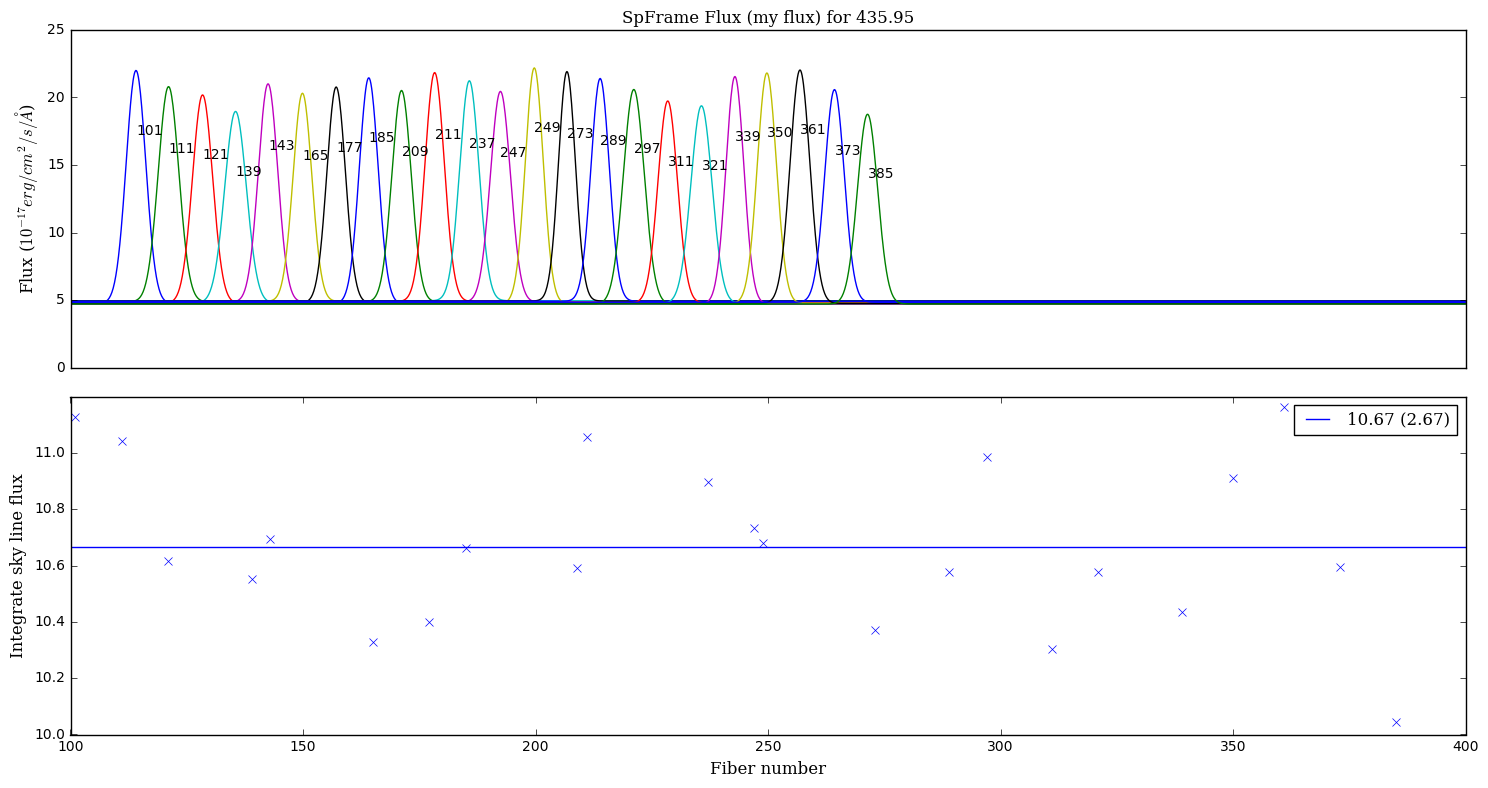

In [16]:
# only look at fibers 100-400, 600-900
line_w = 435.95
fig, (ax1, ax2) = plt.subplots(2,figsize =(15,8))
fluxes = []
if line_w < 630:
    specnos = meta[meta['CAMERAS'] == b'b1']['SPECNO']
    fibs = meta[meta['CAMERAS'] == b'b1']['FIB']
elif line_w > 630:
    specnos = meta[meta['CAMERAS'] == b'r1']['SPECNO']
    fibs = meta[meta['CAMERAS'] == b'r1']['FIB']
    
limits = np.where((fibs>100)&(fibs<400))
specnos = specnos[limits]
fibs = fibs[limits]
for i,specno in enumerate(specnos):
    spectrum = data[specno]
    fib = fibs[i]
    double_plot(line_w, fib, i, spectrum['WAVE'],spectrum['SKY'])

ax1.set_xticks([])
ax1.set_xlim([line_w-1.,line_w+20.])
ax1.set_ylabel("Flux ($10^{-17} erg/cm^{2}/s/\AA$)",fontproperties=font)
ax1.set_title("SpFrame Flux (my flux) for %.2f" % line_w, fontproperties=font)

ax2.axhline(np.mean(fluxes), label = "%.2f (%.2f)" % (np.mean(fluxes), np.std(fluxes)/np.mean(fluxes)*100))
ax2.set_xlabel("Fiber number",fontproperties=font)
ax2.set_ylabel("Integrate sky line flux",fontproperties=font)
ax2.legend(loc='upper right', prop=font)

plt.tight_layout()

## Test with SpFrame/SpCFrame Files

In [15]:
spframe_files = glob.glob(os.getcwd()+'/raw_files/spFrame*')
spcframe_files = glob.glob(os.getcwd()+'/raw_files/spCFrame*') #for wavelength

In [16]:
def get_spectrum(fiber, camera, flux = 'sp'):
    if camera == 'blue':
        spframe = fnmatch.filter(spframe_files, '*b1*')[0]
        spcframe = fnmatch.filter(spcframe_files, '*b1*')[0]
        cam_lims = [365,635]
    elif camera == 'red':
        spframe = fnmatch.filter(spframe_files, '*r1*')[0]
        spcframe = fnmatch.filter(spcframe_files, '*r1*')[0]
        cam_lims = [565,1040]
    sp_hdu  = fits.open(spframe)
    spc_hdu = fits.open(spcframe)
    hdr = sp_hdu[0].header
    airmass = hdr['AIRMASS']
    logwave = spc_hdu[3].data
    wave = 10**(logwave)/10.
    if flux == 'sp':
        sp_sky = sp_hdu[6].data
        sp_hdu0 = sp_hdu[0].data
    elif flux == 'spc':
        sp_sky = spc_hdu[6].data
        sp_hdu0 = spc_hdu[0].data

    
    if fib > 500:
        f = fib-500
    else:
        f = fib
        
    wave_fiber = wave[f]
    limits = np.where((wave_fiber > cam_lims[0]) & (wave_fiber < cam_lims[1]))
    ww = wave_fiber[limits]
    sky = sp_sky[f][limits]+sp_hdu0[f][limits]
    
    return ww, sky

In [20]:
blue_fibs = meta[meta['CAMERAS'] == b'b1']['FIB']

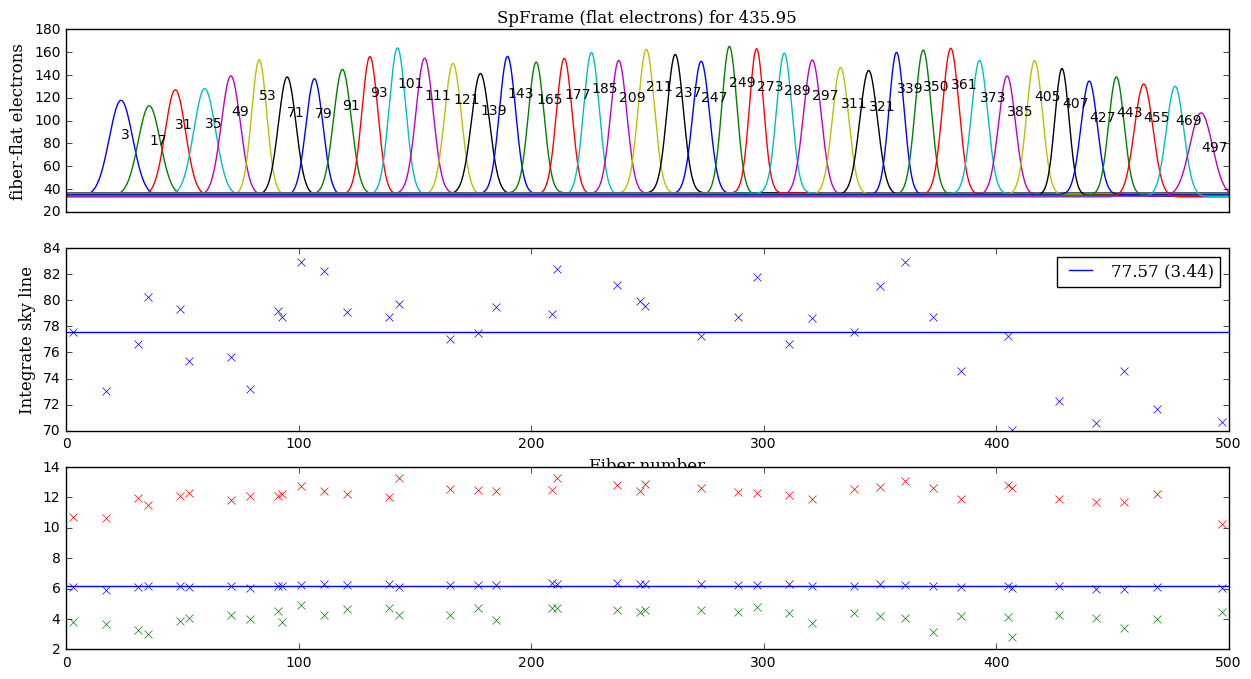

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(3,figsize =(15,8))
fluxes = [] 
line_w = 435.95
pp = []
for i,fib in enumerate(blue_fibs):
    wave, sky = get_spectrum(fib, 'blue', flux = 'sp')
    poisson = double_plot(line_w, fib, i, wave, sky)
    pp.append(poisson)
    ax3.plot(fib, np.mean(poisson),'bx')
    ax3.plot(fib, np.max(poisson),'rx')
    ax3.plot(fib, np.min(poisson),'gx')
    
ax1.set_xticks([])
ax1.set_xlim([line_w-1.,line_w+20.])
ax1.set_ylabel("fiber-flat electrons",fontproperties=font)
ax1.set_title("SpFrame (flat electrons) for %.2f" % line_w, fontproperties=font)

ax2.axhline(np.mean(fluxes), label = "%.2f (%.2f)" % (np.mean(fluxes), np.std(fluxes)))
ax2.set_xlabel("Fiber number",fontproperties=font)
ax2.set_ylabel("Integrate sky line",fontproperties=font)
ax2.legend(loc='upper right', prop=font)

ax3.axhline(np.mean(pp), label = "%.2f" % np.mean(pp))

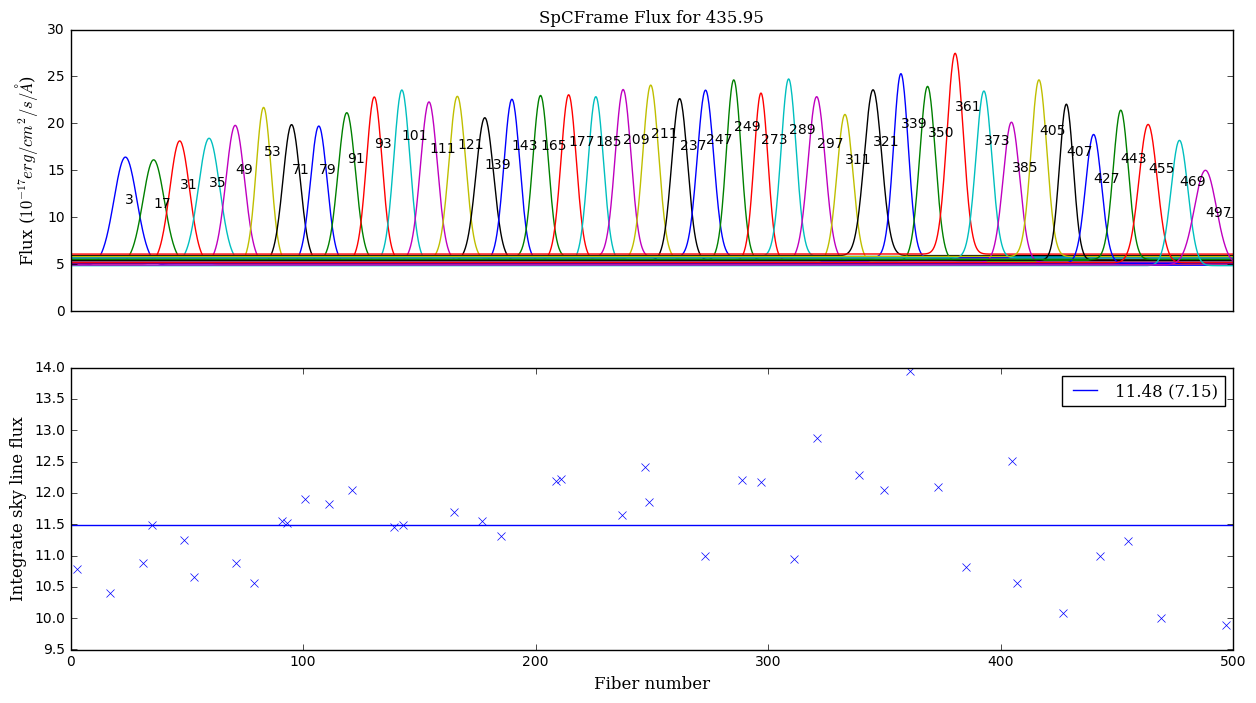

In [36]:
fig, (ax1, ax2) = plt.subplots(2,figsize =(15,8))
fluxes = [] 
for i,fib in enumerate(blue_fibs):
    line_w = 435.95
    wave, sky = get_spectrum(fib, 'blue', flux = 'spc')
    double_plot(line_w, fib, i, wave, sky)

ax1.set_xticks([])
ax1.set_xlim([line_w-1.,line_w+20.])
ax1.set_ylabel("Flux ($10^{-17} erg/cm^{2}/s/\AA$)",fontproperties=font)
ax1.set_title("SpCFrame Flux for %.2f" % line_w, fontproperties=font)

ax2.axhline(np.mean(fluxes), label = "%.2f (%.2f)" % (np.mean(fluxes), np.std(fluxes)/np.mean(fluxes)*100))
ax2.set_xlabel("Fiber number",fontproperties=font)
ax2.set_ylabel("Integrate sky line flux",fontproperties=font)
ax2.legend(loc='upper right', prop=font)

### Look at all QA lines

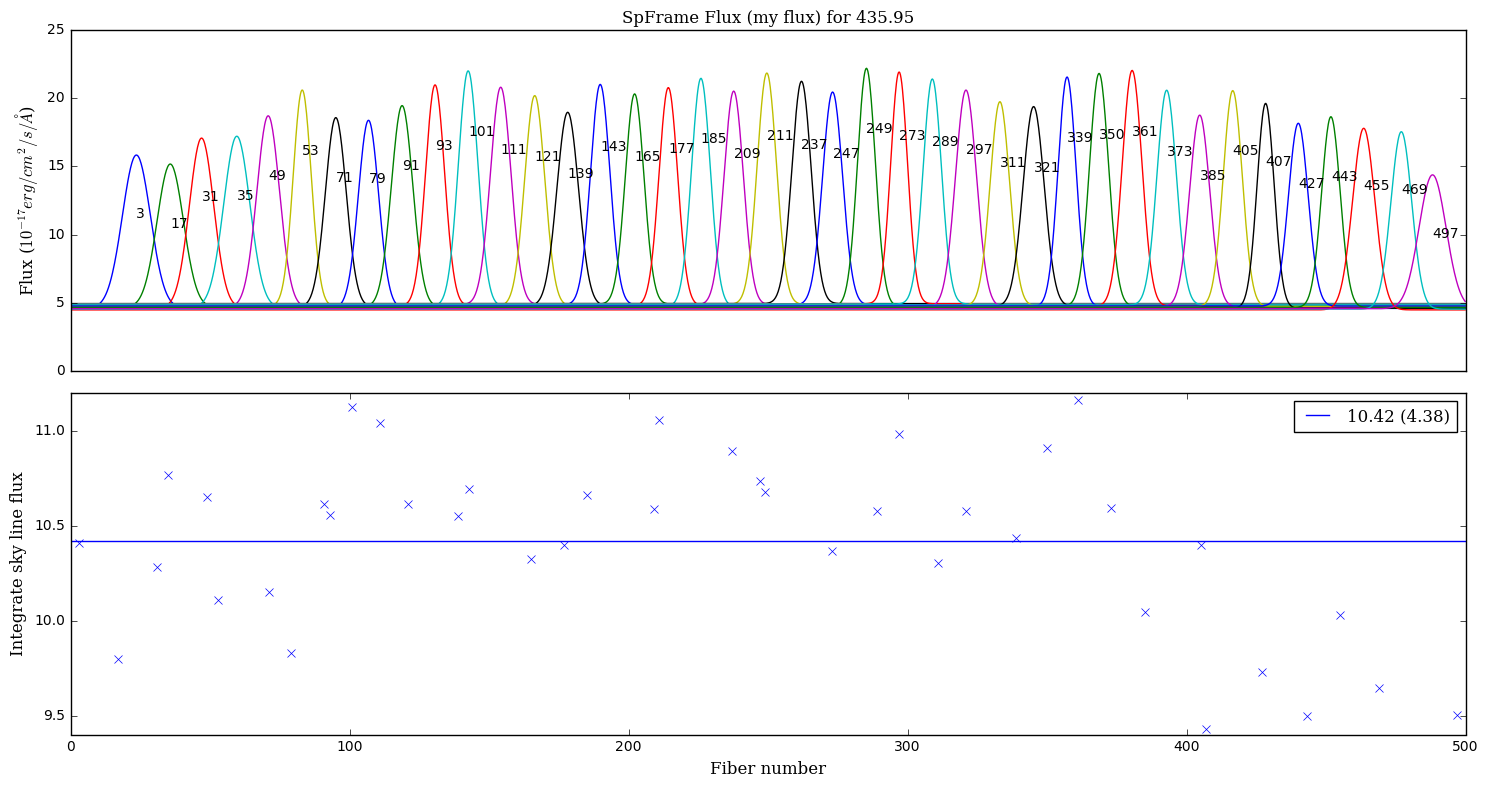

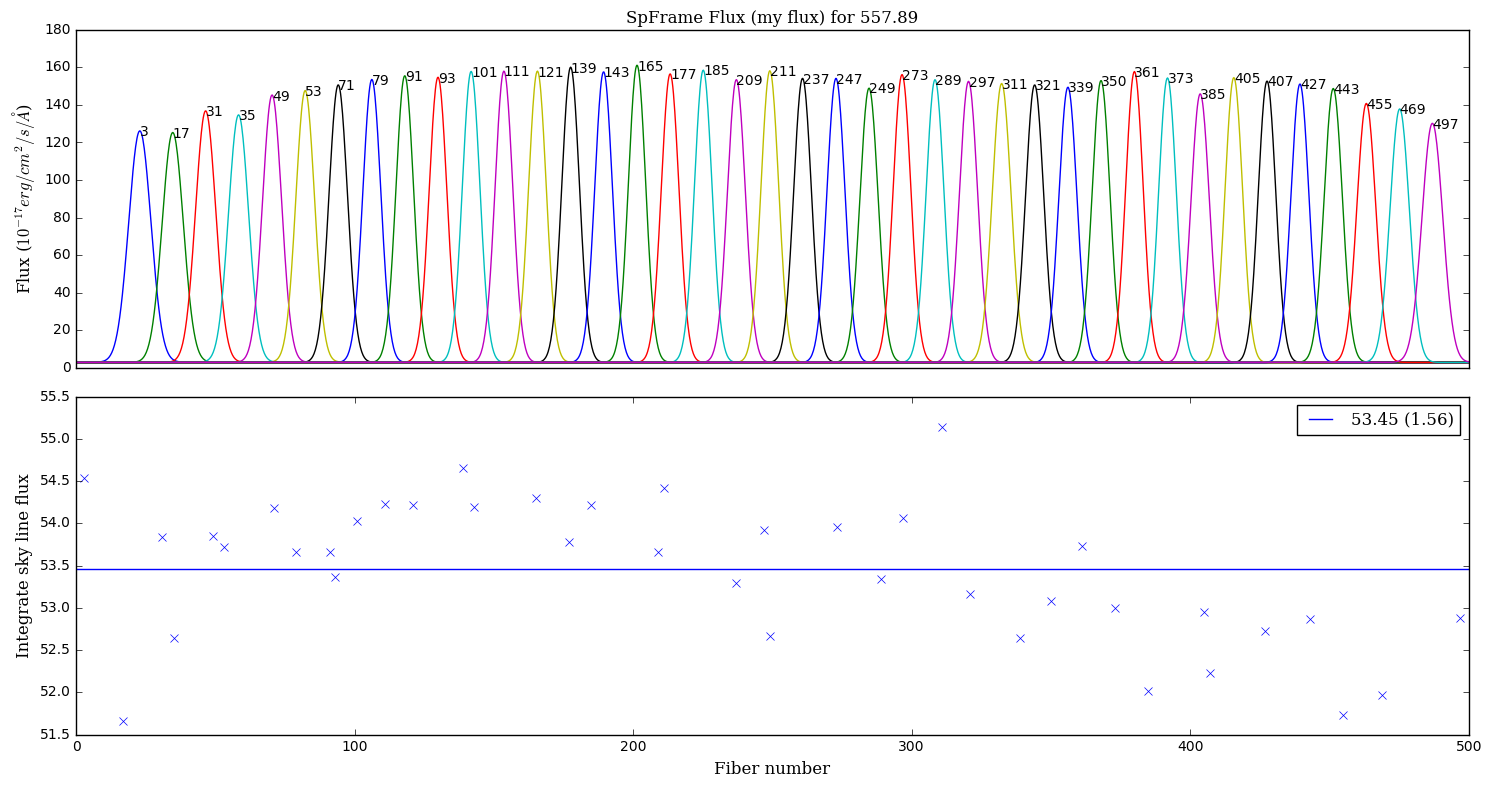

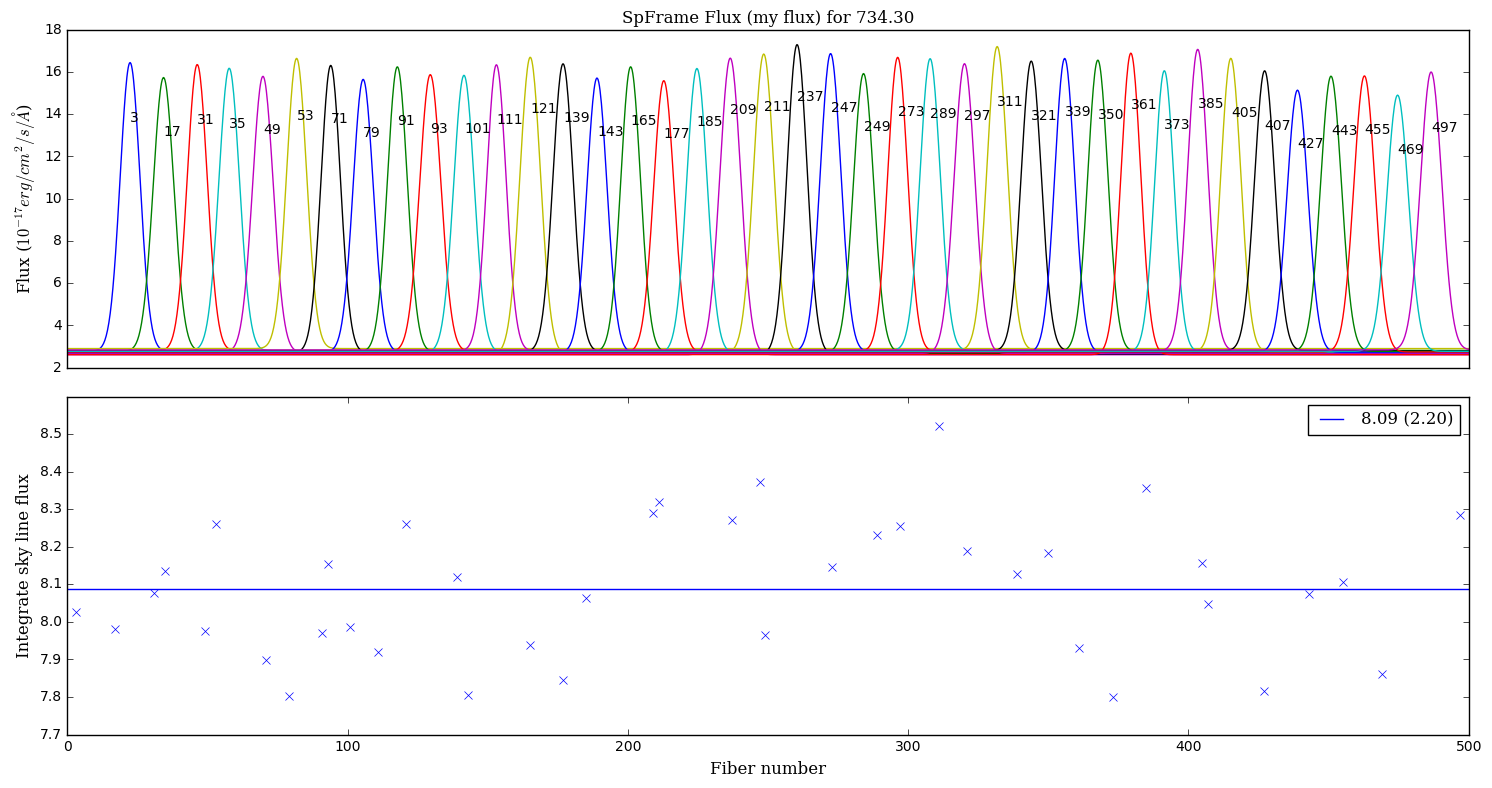

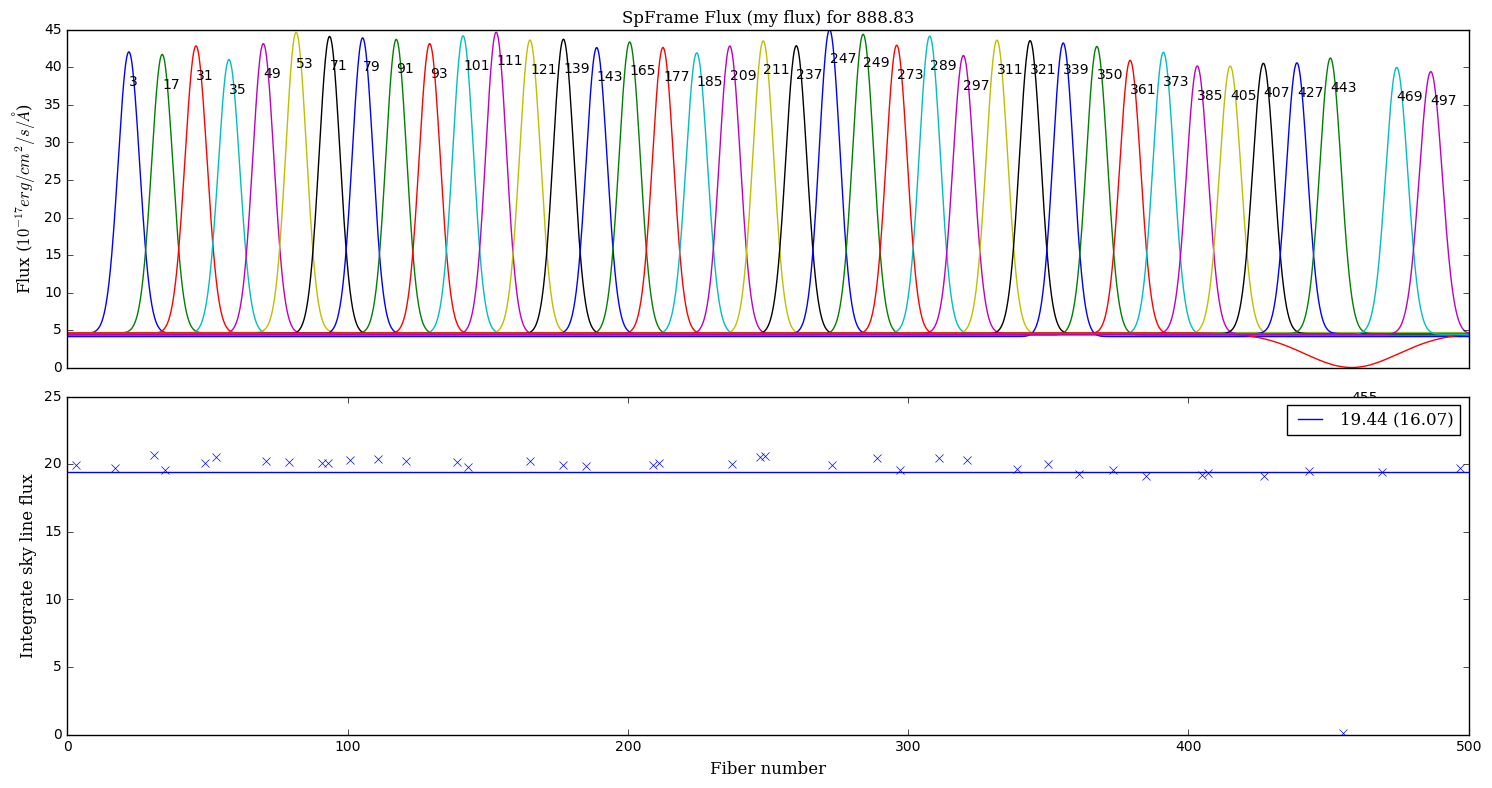

In [17]:
for line_w in qa_lines: 
    fig, (ax1,ax2) = plt.subplots(2,figsize=(15,8))
    
    fluxes = []
    if line_w < 630:
        specnos = meta[meta['CAMERAS'] == b'b1']['SPECNO']
        fibs = meta[meta['CAMERAS'] == b'b1']['FIB']
    elif line_w > 630:
        specnos = meta[meta['CAMERAS'] == b'r1']['SPECNO']
        fibs = meta[meta['CAMERAS'] == b'r1']['FIB']

    for i,specno in enumerate(specnos):
        spectrum = data[specno]
        fib = fibs[i]
        double_plot(line_w, fib, i, spectrum['WAVE'],spectrum['SKY'])
    
    ax1.set_xticks([])
    ax1.set_xlim([line_w-1.,line_w+20.])
    ax1.set_ylabel("Flux ($10^{-17} erg/cm^{2}/s/\AA$)",fontproperties=font)
    ax1.set_title("SpFrame Flux (my flux) for %.2f" % line_w, fontproperties=font)

    ax2.axhline(np.mean(fluxes), label = "%.2f (%.2f)" % (np.mean(fluxes), np.std(fluxes)/np.mean(fluxes)*100))
    ax2.set_xlabel("Fiber number",fontproperties=font)
    ax2.set_ylabel("Integrate sky line flux",fontproperties=font)
    ax2.legend(loc='upper right', prop=font)
    plt.tight_layout(w_pad=0.1)

In [21]:
this_dict = {}
for line_w in qa_lines: 
    
    fluxes = []
    if line_w < 630:
        specnos = meta[meta['CAMERAS'] == b'b1']['SPECNO']
        fibs = meta[meta['CAMERAS'] == b'b1']['FIB']
    elif line_w > 630:
        specnos = meta[meta['CAMERAS'] == b'r1']['SPECNO']
        fibs = meta[meta['CAMERAS'] == b'r1']['FIB']
    for i, specno in enumerate(specnos):
        fib = fibs[i]
        spectrum = data[specno]
        flux = line_flux_calc(line_w, spectrum['WAVE'], spectrum['SKY'])
        fluxes.append(flux)
        #ax[x].plot(fib, flux,'x')
    
    this_dict[line_w] = [np.mean(fluxes), np.std(fluxes)/np.mean(fluxes)*100]
    
print(this_dict)

{888.83: [19.444581628449715, 16.0708458572757], 435.95: [10.418864384341934, 4.3775243759642475], 557.89: [53.453526295715633, 1.5559129930838447], 734.3: [8.0879257244083025, 2.1956038290768296]}


In [20]:
this_dict = {}
for line_w in qa_lines: 
    
    fluxes = []
    if line_w < 630:
        specnos = meta[meta['CAMERAS'] == b'b1']['SPECNO']
        fibs = meta[meta['CAMERAS'] == b'b1']['FIB']
    elif line_w > 630:
        specnos = meta[meta['CAMERAS'] == b'r1']['SPECNO']
        fibs = meta[meta['CAMERAS'] == b'r1']['FIB']
    limits = np.where((fibs>100)&(fibs<400))
    specnos = specnos[limits]
    fibs = fibs[limits]
    for i, specno in enumerate(specnos):
        fib = fibs[i]
        spectrum = data[specno]
        flux = line_flux_calc(line_w, spectrum['WAVE'], spectrum['SKY'])
        fluxes.append(flux)
        #ax[x].plot(fib, flux,'x')
    
    this_dict[line_w] = [np.mean(fluxes), np.std(fluxes)/np.mean(fluxes)*100]
    
print(this_dict)

{888.83: [20.014999772126028, 1.93675824968026], 435.95: [10.667164652048626, 2.6660120008577737], 557.89: [53.725812755755193, 1.3324373315598486], 734.3: [8.1256528762818796, 2.3841241618635762]}


## Look at Different Wavelengths

In [19]:
other_lines = {'HgIa': 4358,'HgIb': 5461,'HgIc': 5770, 'HgId': 5791, 
               'NaIa1':5890, 'NaIa2': 5896, 'NaIb1':6154, 'NaIb2': 6161,
               'OH1': 5542.275, 'OH2': 5605.143, 'OH3': 7780.476, 
               'OH4': 7821.544, 'OH5': 6553.645, 'OH6': 6379.352}

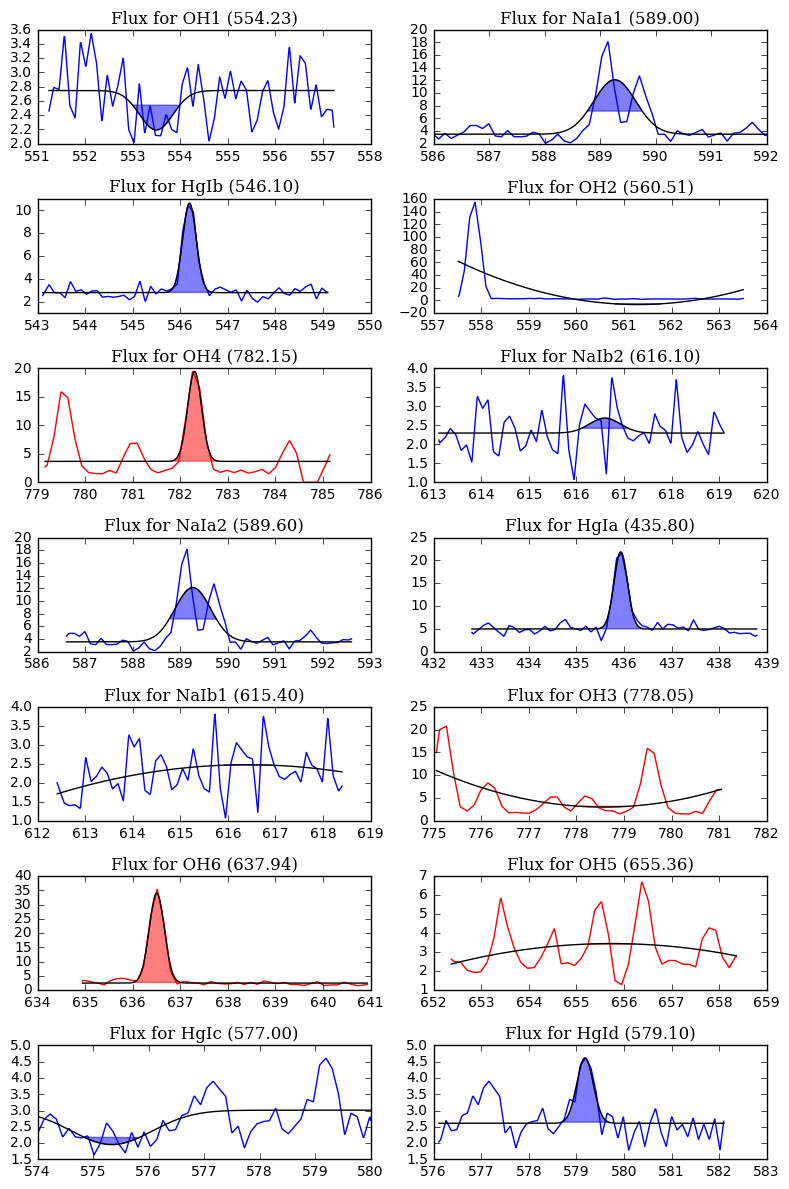

In [89]:
axis_length = int(np.ceil(len(other_lines)/2.))
fig, axes = plt.subplots(axis_length,2,figsize = (8,12))
ax = axes.ravel()
for x, (line_name, line_w) in enumerate(other_lines.items()):
    line_w = line_w/10.
    if line_w < 630:
        xx,dx = np.linspace(370, 630, (630-370)*100, retstep=True) 
        spectrum = data[blue_specno]
        c = 'b'
    elif line_w > 630:
        xx,dx = np.linspace(565, 1040, (1040-565)*100,retstep=True)
        spectrum = data[red_specno]
        c = 'r'

    f = interp1d(spectrum['WAVE'], spectrum['SKY'],bounds_error=False, fill_value=0)
    sky = f(xx)
    segment = np.where((xx>line_w-3.0)&(xx<line_w+3.0))
    wave_segment = xx[segment]
    sky_segment = sky[segment]

    p0 = [20., line_w, 1., 2.]
    popt,pcov = curve_fit(gauss,wave_segment,sky_segment,p0=p0)
    limits1 = np.where((wave_segment>(popt[1]-.5))&(wave_segment<(popt[1]+.5)))

    ax[x].plot(wave_segment, sky_segment, color = c,label = 'data')
    ax[x].plot(wave_segment, gauss(wave_segment, *popt), color = 'k', label = 'fit')
    ax[x].fill(wave_segment[limits1], gauss(wave_segment[limits1], *popt), color = c,alpha = 0.5)
    ax[x].set_title("Flux for %s (%.2f)" % (line_name, line_w), fontproperties=font)
plt.tight_layout()

In [20]:
good_other_lines = {'HgIa': 4358,'HgIb': 5461, 'HgId': 5791,'OH4': 7821.544, 'OH6': 6379.352}

In [19]:
#fig, axes = plt.subplots(len(good_other_lines),figsize =(10,12))
#ax = axes.ravel()

this_dict = {}
for x, (line_name, line_w) in enumerate(good_other_lines.items()):
    line_w = line_w/10.
    fluxes = []
    if line_w < 630:
        specnos = meta[meta['CAMERAS'] == b'b1']['SPECNO']
        fibs = meta[meta['CAMERAS'] == b'b1']['FIB']
    elif line_w > 630:
        specnos = meta[meta['CAMERAS'] == b'r1']['SPECNO']
        fibs = meta[meta['CAMERAS'] == b'r1']['FIB']
    
    for i, specno in enumerate(specnos):
        fib = fibs[i]
        spectrum = data[specno]
        flux = line_flux_calc(line_w, spectrum['WAVE'], spectrum['SKY'])
        fluxes.append(flux)
        #ax[x].plot(fib, flux,'x')
    
    #ax[x].axhline(np.mean(fluxes), label = "%.2f (%.2f)" % ())
    this_dict[line_name] = [np.mean(fluxes), np.std(fluxes)/np.mean(fluxes)*100]
    #ax[x].legend(loc='upper right', prop=font)
    #ax[x].set_title("Flux in %s" % line_name, fontproperties=font)
    #ax[x].set_xlabel("Fiber number", fontproperties=font)
#plt.tight_layout()
print(this_dict)

{'HgIb': [5.5844284680278919, 3.1573420261678544], 'OH4': [9.4605948497922263, 1.8162606776113637], 'HgId': [3.3178467502650664, 9.0026644845689177], 'HgIa': [10.414747894455376, 4.3767251037470656], 'OH6': [1.5397858665242363, 5.7961364343420261]}


## Look at Continuum

In [24]:
def cont_mean(low, high, wave, sky):
    if low < 630:
        xx, dx = np.linspace(370, 630, (630-370)*100, retstep=True) 
    elif low > 630:
        xx, dx = np.linspace(565, 1040, (1040-565)*100,retstep=True)
    f = interp1d(wave, sky, bounds_error=False, fill_value=0)
    sky = f(xx)
    segment = np.where((xx>low)&(xx<high))
    wave_segment = xx[segment]
    sky_segment = sky[segment]
    
    return np.mean(sky_segment)

In [25]:
bands = {'bA':[388,389],'bB':[450,475], 'bC':[538,543],'bD':[601,604],'bE':[601,604],
         'rA':[670,682],'rB':[716,722],'rC':[816,826],'rD':[917,921],'rE':[976,978]}
#bands = {'bA':[388,389],'bB':[450,475], 'bE':[601,604],
#         'rA':[670,682],'rB':[716,722],'rD':[917,921],}

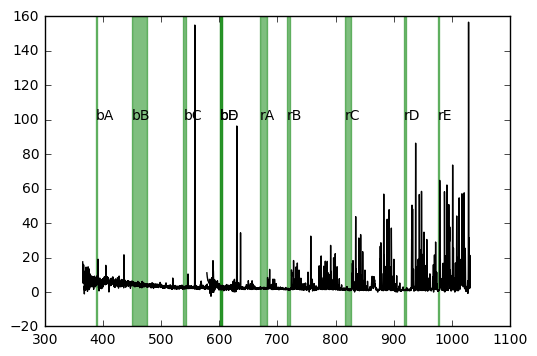

In [20]:
blue_spectrum = data[blue_specno]
red_spectrum = data[red_specno]
plt.plot(blue_spectrum['WAVE'], blue_spectrum['SKY'],'k')
plt.plot(red_spectrum['WAVE'], red_spectrum['SKY'],'k')
for band, limits in bands.items():
    plt.axvspan(limits[0], limits[1], alpha = 0.5, color = 'green')
    plt.text(limits[0], 100, band)

{'rB': [1.6200000000000001, 3.9700000000000002], 'bE': [2.54, 4.6299999999999999], 'bA': [6.46, 10.470000000000001], 'bC': [2.5699999999999998, 3.25], 'bB': [4.4199999999999999, 1.8600000000000001], 'rC': [1.5800000000000001, 3.23], 'rD': [1.0, 5.9299999999999997], 'rA': [2.02, 5.3600000000000003], 'rE': [0.85999999999999999, 7.8099999999999996], 'bD': [2.54, 4.6299999999999999]}


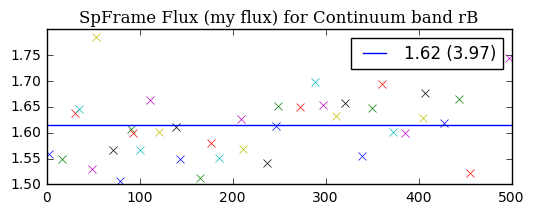

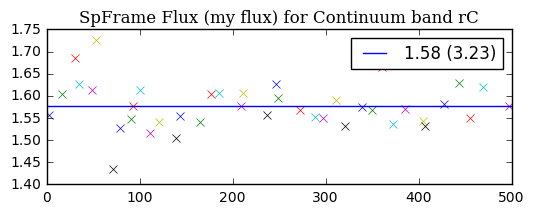

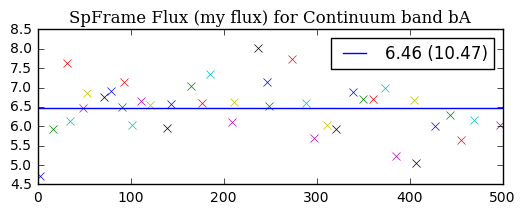

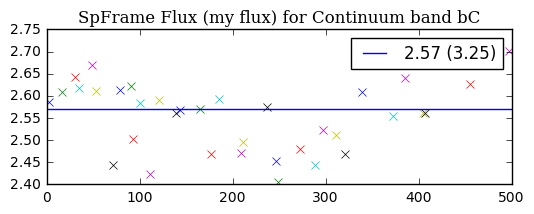

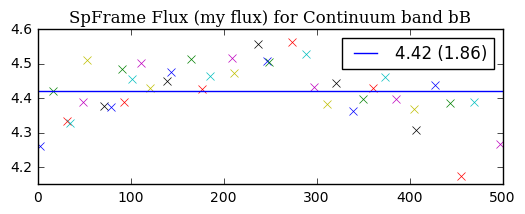

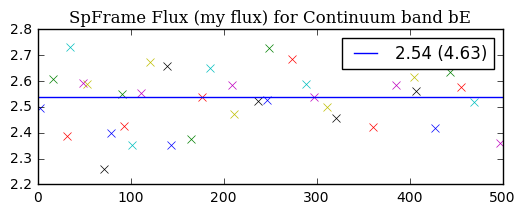

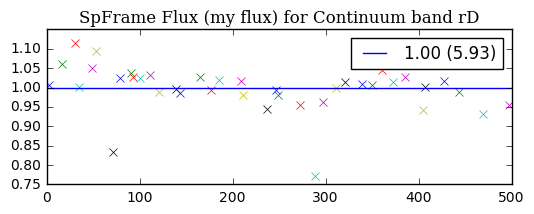

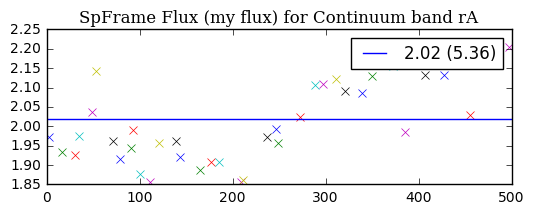

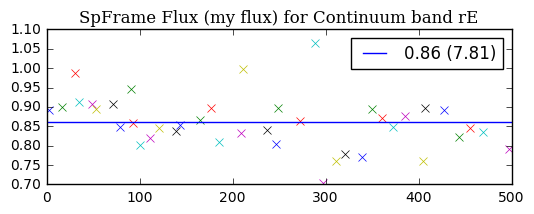

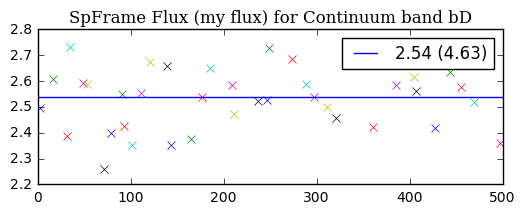

In [118]:
this_dict = {}
for band, limits in bands.items():
    plt.figure(figsize=(6,2))
    fluxes = []
    if limits[0] < 630:
        specnos = meta[meta['CAMERAS'] == b'b1']['SPECNO']
        fibs = meta[meta['CAMERAS'] == b'b1']['FIB']
    elif limits[0] > 630:
        specnos = meta[meta['CAMERAS'] == b'r1']['SPECNO']
        fibs = meta[meta['CAMERAS'] == b'r1']['FIB']

    for i,specno in enumerate(specnos):
        spectrum = data[specno]
        fib = fibs[i]
        cont_flux = cont_mean(limits[0], limits[1], spectrum['WAVE'], spectrum['SKY'])
        fluxes.append(cont_flux)
        plt.plot(fib, cont_flux, 'x')
    this_dict[band] = [np.round(np.mean(fluxes),2), np.round(np.std(fluxes)/np.mean(fluxes)*100,2)]

    plt.axhline(np.mean(fluxes), label = "%.2f (%.2f)" % (np.mean(fluxes), np.std(fluxes)/np.mean(fluxes)*100))
    plt.legend()
    plt.title("SpFrame Flux (my flux) for Continuum band %s" % band, fontproperties=font)
print(this_dict)

## Results from Many Plates/Images

In [21]:
MetaDark = np.load('/Users/parkerf/Research/SkyModel/BOSS_Sky/Analysis/MetaData/dark_100_meta_rich.npy')

In [31]:
def get_plate_mean(filen, image, line_w, inner=False):
    
    data = np.load('/Users/parkerf/Desktop/sample_spframe_files/'+filen)
    plate = int(filen[-23:-19])
    plate_meta = MetaDark[MetaDark['PLATE'] == plate]
    meta = plate_meta[plate_meta['IMG'] == image]
    if line_w < 630:
        specnos = meta[meta['CAMERAS'] == b'b1']['SPECNO']
        fibs = meta[meta['CAMERAS'] == b'b1']['FIB']
    elif line_w > 630:
        specnos = meta[meta['CAMERAS'] == b'r1']['SPECNO']
        fibs = meta[meta['CAMERAS'] == b'r1']['FIB']

    fluxes = []  
    if inner:
        l = np.where((fibs>100)&(fibs<400))
        specnos = specnos[l]
        fibs = fibs[l]
    for spec in specnos:
        spectrum = data[spec]
        flux = line_flux_calc(line_w, spectrum['WAVE'], spectrum['SKY'])
        fluxes.append(flux)
        
    mean = np.mean(fluxes)
    disp = np.std(fluxes)/np.mean(fluxes)*100
    
    return mean, disp  

In [32]:
def get_plate_cont_mean(filen, image, limits, inner=False):
    
    data = np.load('/Users/parkerf/Desktop/sample_spframe_files/'+filen)
    plate = int(filen[-23:-19])
    plate_meta = MetaDark[MetaDark['PLATE'] == plate]
    meta = plate_meta[plate_meta['IMG'] == image]
    if line_w < 630:
        specnos = meta[meta['CAMERAS'] == b'b1']['SPECNO']
        fibs = meta[meta['CAMERAS'] == b'b1']['FIB']
    elif line_w > 630:
        specnos = meta[meta['CAMERAS'] == b'r1']['SPECNO']
        fibs = meta[meta['CAMERAS'] == b'r1']['FIB']

    fluxes = []   
    if inner:
        l = np.where((fibs>100)&(fibs<400))
        specnos = specnos[l]
        fibs = fibs[l]
    for spec in specnos:
        spectrum = data[spec]
        flux = cont_mean(limits[0], limits[1], spectrum['WAVE'], spectrum['SKY'])
        fluxes.append(flux)
        
    mean = np.mean(fluxes)
    disp = np.std(fluxes)/np.mean(fluxes)*100
    
    return mean, disp  

/Users/parkerf/anaconda3/lib/python3.5/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


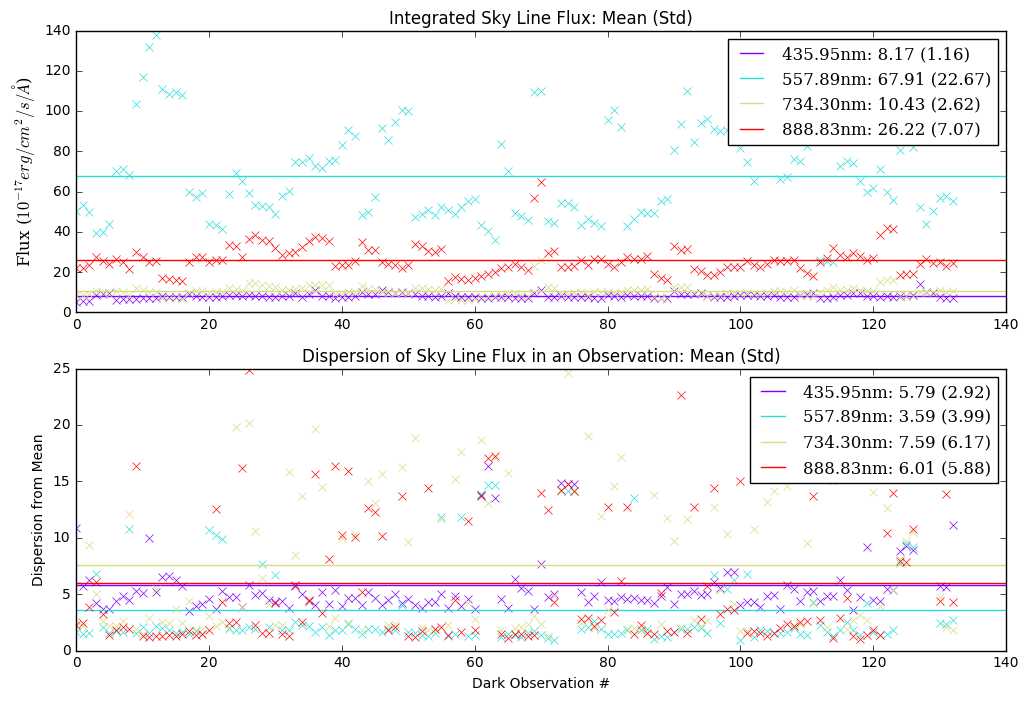

In [49]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,8))

color=iter(cm.rainbow(np.linspace(0,1,len(qa_lines))))
for line_w in qa_lines:
    c=next(color)
    Mean = []
    Disp = []
    for filen in os.listdir('/Users/parkerf/Desktop/sample_spframe_files/'):
        plate = int(filen[-23:-19])
        for image in np.unique(MetaDark[MetaDark['PLATE'] == plate]['IMG']):
            mean, disp = get_plate_mean(filen, image, line_w)
            Mean.append(mean)
            Disp.append(disp)
    ax1.plot(Mean, 'x', c=c)
    ax2.plot(Disp, 'x', c=c)
    ax1.axhline(np.mean(Mean), c=c, label = "%.2fnm: %.2f (%.2f)" % (line_w, np.mean(Mean), np.std(Mean)))
    ax2.axhline(np.mean(Disp), c=c, label = "%.2fnm: %.2f (%.2f)" % (line_w, np.mean(Disp), np.std(Disp)))
    ax1.legend(loc='upper right', prop=font)
    ax1.set_title("Integrated Sky Line Flux: Mean (Std)")
    ax1.set_ylabel("Flux ($10^{-17} erg/cm^{2}/s/\AA$)",fontproperties=font)
    ax2.legend(loc='upper right', prop=font)
    ax2.set_title("Dispersion of Sky Line Flux in an Observation: Mean (Std)")
    ax2.set_ylabel("Dispersion from Mean")
    ax2.set_xlabel("Dark Observation #")

/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in double_scalars


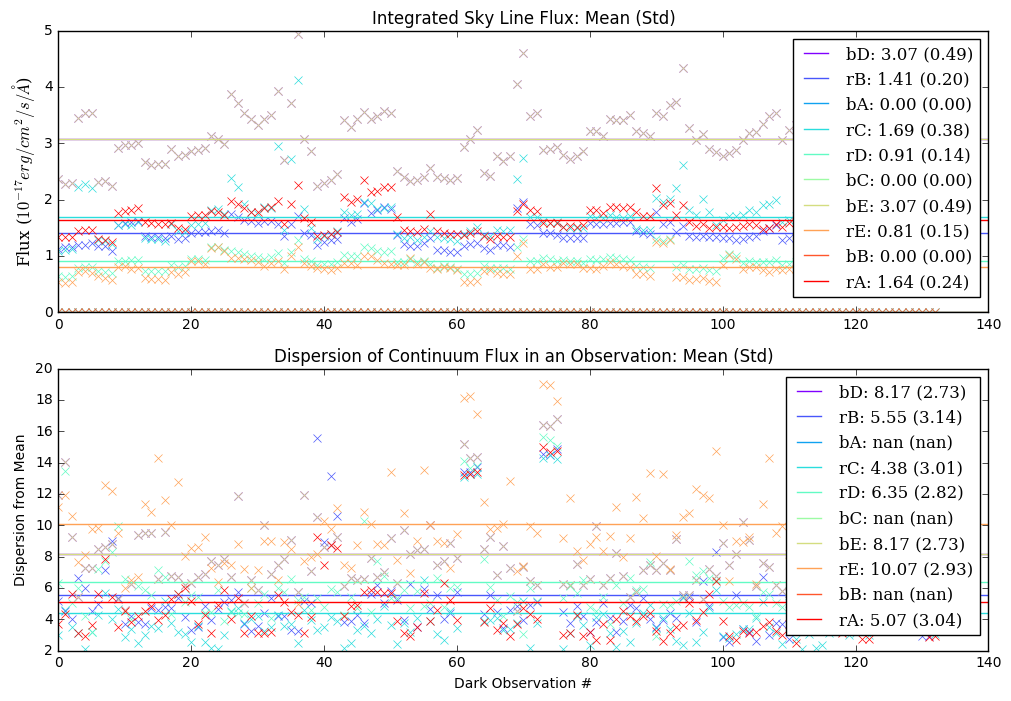

In [36]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,8))

color=iter(cm.rainbow(np.linspace(0,1,len(bands))))
for band, limits in bands.items():
    c=next(color)
    Mean = []
    Disp = []
    for filen in os.listdir('/Users/parkerf/Desktop/sample_spframe_files/'):
        plate = int(filen[-23:-19])
        for image in np.unique(MetaDark[MetaDark['PLATE'] == plate]['IMG']):
            mean, disp = get_plate_cont_mean(filen, image, limits)
            Mean.append(mean)
            Disp.append(disp)
    ax1.plot(Mean, 'x', c=c)
    ax2.plot(Disp, 'x', c=c)
    ax1.axhline(np.mean(Mean), c=c, label = "%s: %.2f (%.2f)" % (band, np.mean(Mean), np.std(Mean)))
    ax2.axhline(np.mean(Disp), c=c, label = "%s: %.2f (%.2f)" % (band, np.mean(Disp), np.std(Disp)))
    ax1.legend(loc='upper right', prop=font)
    ax1.set_title("Integrated Sky Line Flux: Mean (Std)")
    ax1.set_ylabel("Flux ($10^{-17} erg/cm^{2}/s/\AA$)",fontproperties=font)
    ax2.legend(loc='upper right', prop=font)
    ax2.set_title("Dispersion of Continuum Flux in an Observation: Mean (Std)")
    ax2.set_ylabel("Dispersion from Mean")
    ax2.set_xlabel("Dark Observation #")

/Users/parkerf/anaconda3/lib/python3.5/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


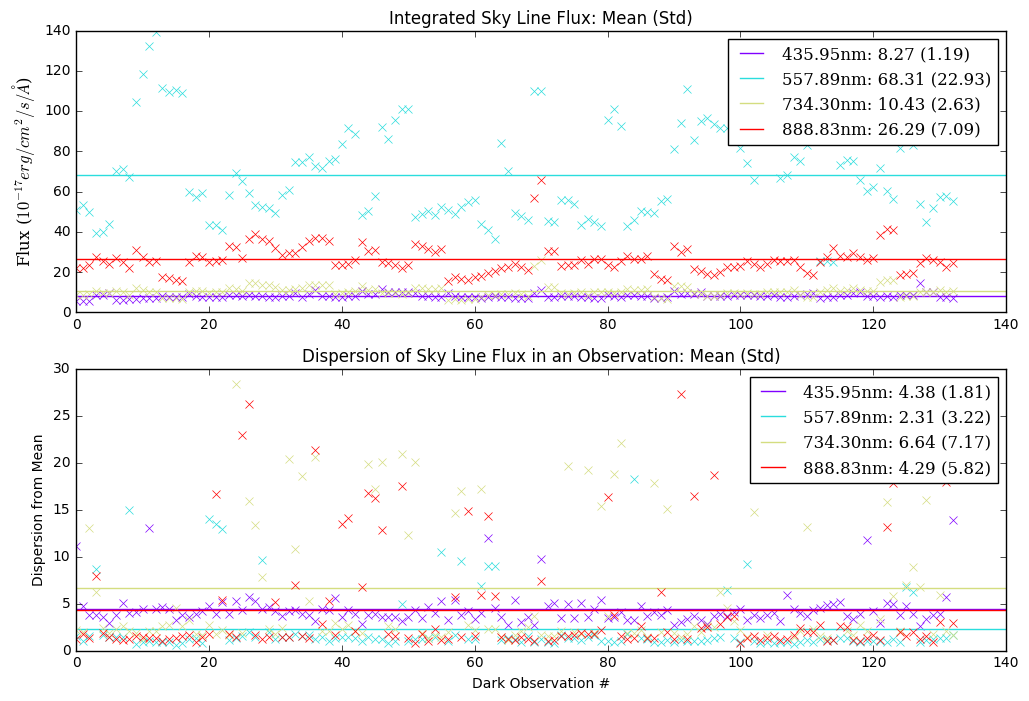

In [35]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,8))

color=iter(cm.rainbow(np.linspace(0,1,len(qa_lines))))
for line_w in qa_lines:
    c=next(color)
    Mean = []
    Disp = []
    for filen in os.listdir('/Users/parkerf/Desktop/sample_spframe_files/'):
        plate = int(filen[-23:-19])
        for image in np.unique(MetaDark[MetaDark['PLATE'] == plate]['IMG']):
            mean, disp = get_plate_mean(filen, image, line_w, inner=True)
            Mean.append(mean)
            Disp.append(disp)
    ax1.plot(Mean, 'x', c=c)
    ax2.plot(Disp, 'x', c=c)
    ax1.axhline(np.mean(Mean), c=c, label = "%.2fnm: %.2f (%.2f)" % (line_w, np.mean(Mean), np.std(Mean)))
    ax2.axhline(np.mean(Disp), c=c, label = "%.2fnm: %.2f (%.2f)" % (line_w, np.mean(Disp), np.std(Disp)))
    ax1.legend(loc='upper right', prop=font)
    ax1.set_title("Integrated Sky Line Flux: Mean (Std)")
    ax1.set_ylabel("Flux ($10^{-17} erg/cm^{2}/s/\AA$)",fontproperties=font)
    ax2.legend(loc='upper right', prop=font)
    ax2.set_title("Dispersion of Sky Line Flux in an Observation: Mean (Std)")
    ax2.set_ylabel("Dispersion from Mean")
    ax2.set_xlabel("Dark Observation #")

## Correlation with Single Components

First want to see if there is any correlation between line fluxes and:
- Location on Detector
- Location on Focal Plate
- Location on Sky
- Location relative to other fibers

In [23]:
def plot_linear_corr(name, plate, image, function, lines):
    fig, axes = plt.subplots(2, len(lines)//2)
    ax = axes.ravel()
    for i, line_w in enumerate(lines):
        xx, flux = function(plate, image, line_w)
        A = np.stack((np.ones(len(xx)),xx))
        lsq = lstsq(A.T,np.array(flux))
        model = np.dot(A.T,lsq[0])
        resids = flux-model
        R_1 = np.sum([(i)**2 for i in resids])
        R_2 = np.sum([(i-np.mean(flux))**2 for i in flux]) 
        R = 1-(R_1/R_2)  
        ax[i].plot(xx, flux, 'x')
        ax[i].plot(xx, model,label = ("$R^{2}$: %.2f" % R))
        ax[i].set_xlabel("r",fontproperties=font)
        ax[i].set_ylabel("Flux for %.2f" % line_w,fontproperties=font)
        ax[i].legend(prop=font)
    st = fig.suptitle("Linear Correlation for %s" % name, fontproperties=font)
    st.set_y(1.05)
    fig.subplots_adjust(top=0.85)
    plt.tight_layout()

In [24]:
def multi_plate_response(name, function, lines):
    fig, axes = plt.subplots(2, len(lines)//2)
    ax = axes.ravel()
    for i, line_w in enumerate(lines):
            R2 = []
            for plate in np.unique(MetaDark['PLATE'])[0:5]:
                for image in np.unique(MetaDark[MetaDark['PLATE']==plate]['IMG']):
                    xx, flux = function(plate,image,line_w)
                    A = np.stack((np.ones(len(xx)),xx))
                    lsq = lstsq(A.T,np.array(flux))
                    model = np.dot(A.T,lsq[0])
                    resids = flux-model
                    R_1 = np.sum([(i)**2 for i in resids])
                    R_2 = np.sum([(i-np.mean(flux))**2 for i in flux]) 
                    R = 1-(R_1/R_2) 
                    R2.append(R)
            ax[i].plot(R2, 'x')
            ax[i].axhline(np.mean(R2), label = "%.2f (%.2f)" %(np.mean(R2), np.std(R2)))
            ax[i].set_ylabel("%.2f" % line_w, fontproperties=font)
            ax[i].legend(prop=font)
    st = fig.suptitle("$R^{2}$ values (goodness of fit) for %s" % name, fontproperties=font)
    st.set_y(1.05)
    fig.subplots_adjust(top=0.85)
    plt.tight_layout()       

#### Plate Location

In [25]:
def plate_location(plate, image, line_w):
    data = np.load(DATA_DIR+'%d_calibrated_sky.npy' % plate)
    plate_meta = MetaDark[MetaDark['PLATE'] == plate]
    meta = plate_meta[plate_meta['IMG'] == image]
    airmass = np.unique(meta['AIRMASS'])
    
    if line_w < 630:
        my_meta = meta[meta['CAMERAS'] == b'b1']
    elif line_w > 630:
        my_meta = meta[meta['CAMERAS'] == b'r1']
    
    xx = []
    yy = []
    rr = []
    flux = []
    for line in my_meta:
        spec = line['SPECNO']
        xx.append(line['XFOCAL_x'])
        yy.append(line['YFOCAL_x'])
        rr.append(np.sqrt(line['XFOCAL_x']**2+line['YFOCAL_x']**2))
        spectrum = data[spec]
        flux.append(line_flux_calc(line_w, spectrum['WAVE'], spectrum['SKY']))

    return rr, flux

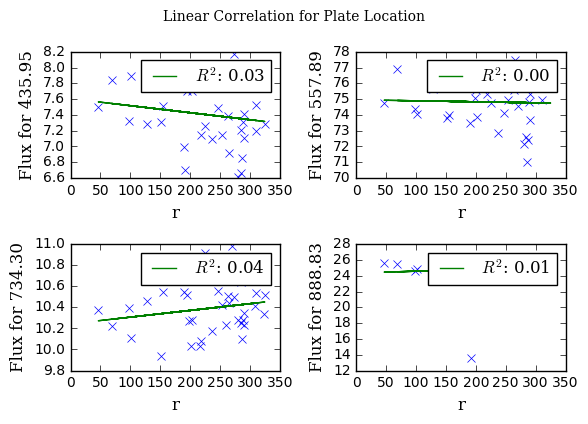

In [75]:
#For a random plate
plate = np.random.choice(np.unique(MetaDark['PLATE']),1)
image = np.random.choice(np.unique(MetaDark[MetaDark['PLATE']==plate]['IMG']),1)
plot_linear_corr('Plate Location', plate, image ,plate_location, qa_lines)

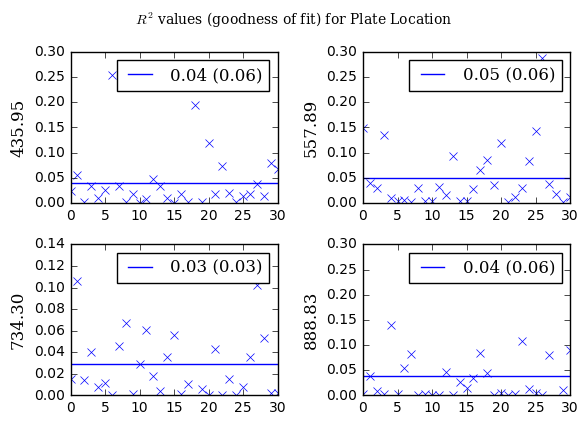

In [80]:
multi_plate_response('Plate Location', plate_location, qa_lines)

#### Detector Location

In [26]:
def detector_location(plate, image, line_w):
    data = np.load(DATA_DIR+'%d_calibrated_sky.npy' % plate)
    plate_meta = MetaDark[MetaDark['PLATE'] == plate]
    meta = plate_meta[plate_meta['IMG'] == image]
    airmass = np.unique(meta['AIRMASS'])
    
    if line_w < 630:
        my_meta = meta[meta['CAMERAS'] == b'b1']
    elif line_w > 630:
        my_meta = meta[meta['CAMERAS'] == b'r1']
    
    fib = []
    flux = []
    for line in my_meta:
        spec = line['SPECNO']
        fib.append(line['FIB'])
        spectrum = data[spec]
        flux.append(line_flux_calc(line_w, spectrum['WAVE'], spectrum['SKY']))

    return fib, flux

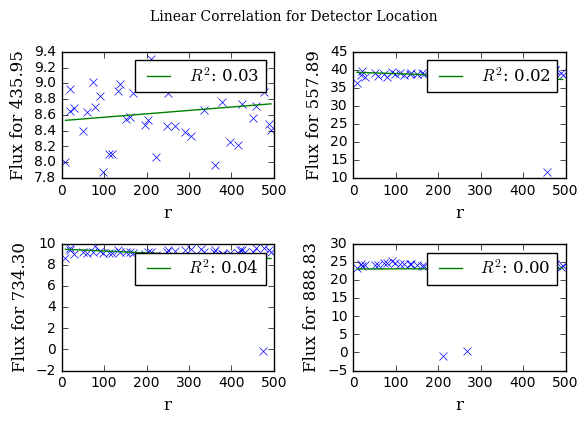

In [82]:
#For a random plate
plate = np.random.choice(np.unique(MetaDark['PLATE']),1)
image = np.random.choice(np.unique(MetaDark[MetaDark['PLATE']==plate]['IMG']),1)
plot_linear_corr('Detector Location', plate, image , detector_location, qa_lines)

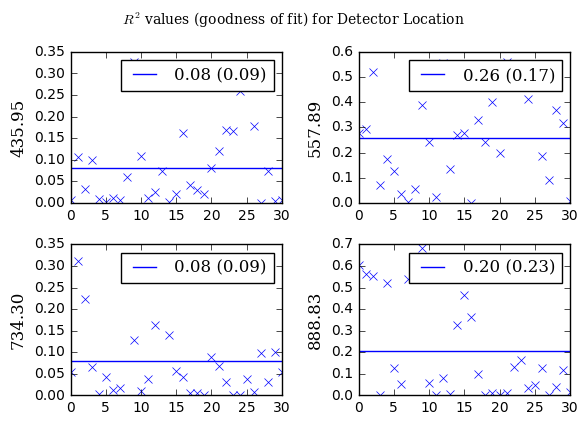

In [84]:
multi_plate_response('Detector Location', detector_location, qa_lines)

#### Sky Location (Separation between Fiber and Field Center)

In [27]:
def sky_location(plate, image, line_w):
    data = np.load(DATA_DIR+'%d_calibrated_sky.npy' % plate)
    plate_meta = MetaDark[MetaDark['PLATE'] == plate]
    meta = plate_meta[plate_meta['IMG'] == image]
    airmass = np.unique(meta['AIRMASS'])
    field_RA = np.unique(meta['RA'])
    field_DEC = np.unique(meta['DEC'])
    field_center = SkyCoord(ra=field_RA, dec = field_DEC, unit=u.deg, frame = 'icrs')
    
    if line_w < 630:
        my_meta = meta[meta['CAMERAS'] == b'b1']
    elif line_w > 630:
        my_meta = meta[meta['CAMERAS'] == b'r1']
    
    sep = []
    flux = []
    for line in my_meta:
        spec = line['SPECNO']
        fiber_RA = line['FIBER_RA']
        fiber_DEC = line['FIBER_DEC']
        Separation = SkyCoord(ra=fiber_RA, dec = fiber_DEC, unit=u.deg, frame='icrs').separation(field_center).value[0]
        sep.append(Separation)
        
        spectrum = data[spec]
        flux.append(line_flux_calc(line_w, spectrum['WAVE'], spectrum['SKY']))

    return sep, flux

In [73]:
def sky_coords(plate, image, line_w):
    data = np.load(DATA_DIR+'%d_calibrated_sky.npy' % plate)
    plate_meta = MetaDark[MetaDark['PLATE'] == plate]
    meta = plate_meta[plate_meta['IMG'] == image]
    airmass = np.unique(meta['AIRMASS'])
    
    if line_w < 630:
        my_meta = meta[meta['CAMERAS'] == b'b1']
    elif line_w > 630:
        my_meta = meta[meta['CAMERAS'] == b'r1']
    
    sky_coords = []
    my_flux = []
    for line in my_meta:
        spec = line['SPECNO']
        fiber_RA = line['FIBER_RA']
        fiber_DEC = line['FIBER_DEC']
        sky_coords.append(SkyCoord(ra=fiber_RA, dec = fiber_DEC, unit=u.deg, frame='icrs'))

        spectrum = data[spec]
        my_flux.append(line_flux_calc(line_w, spectrum['WAVE'], spectrum['SKY'])[0])

    return sky_coords, my_flux

In [75]:
qa_lines

[435.95, 557.89, 734.3, 888.83]

In [74]:
plate = np.random.choice(np.unique(MetaDark['PLATE']),1)
image = np.random.choice(np.unique(MetaDark[MetaDark['PLATE']==plate]['IMG']),1)

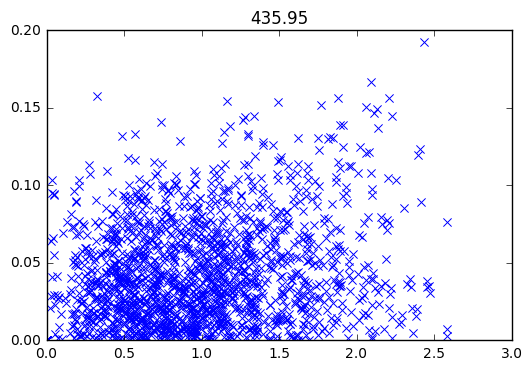

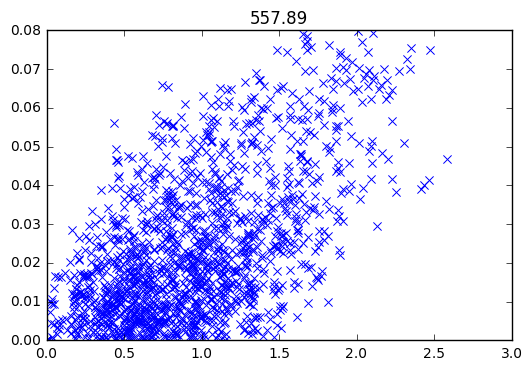

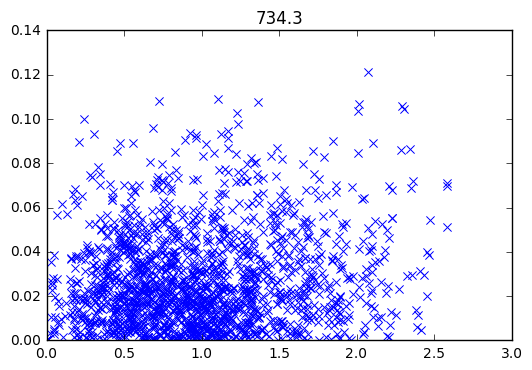

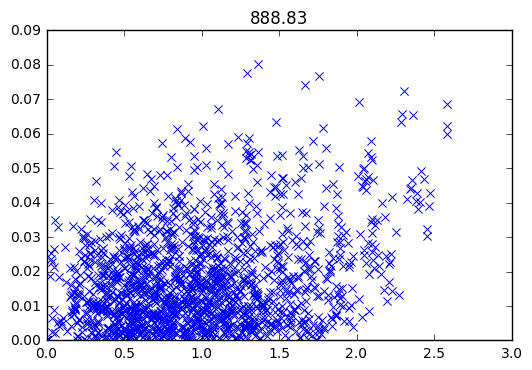

In [89]:
for line in qa_lines:

    sky_cs, ff = sky_coords(plate, image, line)
    sky_cs = np.array(sky_cs)
    ff = np.array(ff)
    ff = ff/np.mean(ff)
    ok = np.where((ff < np.mean(ff)+2*np.std(ff)) & (ff >np.mean(ff)-2*np.std(ff)))
    FF = ff[ok]
    sky_cs = sky_cs[ok]
    seps = []
    flux_diff = []
    for i, sky_coord_i in enumerate(sky_cs):
        for j, sky_coord_j in enumerate(sky_cs):
            seps.append(sky_coord_i.separation(sky_coord_j).value)
            flux_diff.append(np.abs(FF[j] - FF[i]))
    plt.figure()
    plt.plot(seps, flux_diff, 'x')
    plt.title(line)
    plt.show()

In [64]:
Want correlation function. 

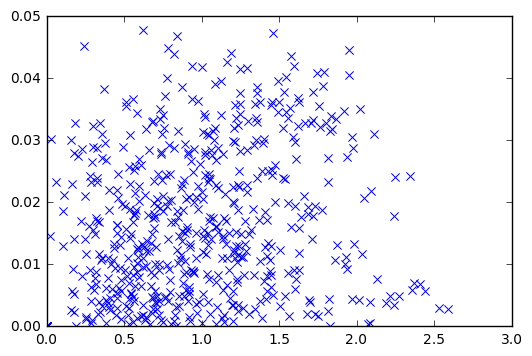

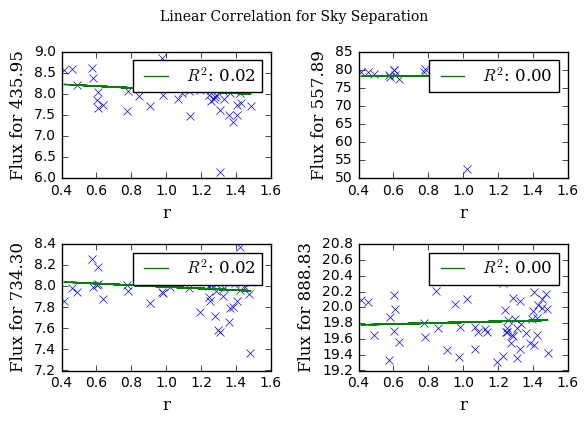

In [88]:
#For a random plate
plate = np.random.choice(np.unique(MetaDark['PLATE']),1)
image = np.random.choice(np.unique(MetaDark[MetaDark['PLATE']==plate]['IMG']),1)
plot_linear_corr('Sky Separation', plate, image , sky_location, qa_lines)

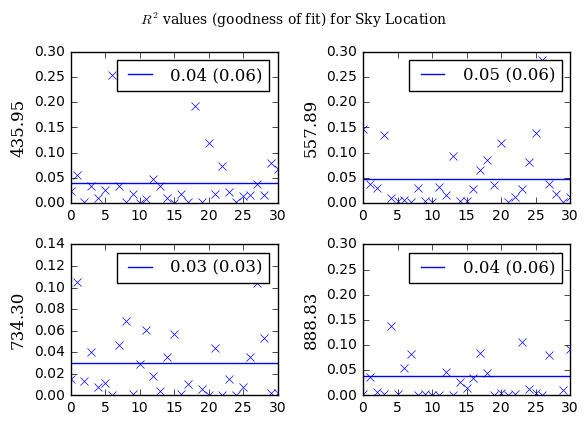

In [89]:
multi_plate_response('Sky Location', sky_location, qa_lines)

#### Separation between fiber and closest sky fiber

In [28]:
def closest_sky_location(plate, image, line_w):
    data = np.load(DATA_DIR+'%d_calibrated_sky.npy' % plate)
    plate_meta = MetaDark[MetaDark['PLATE'] == plate]
    meta = plate_meta[plate_meta['IMG'] == image]
    airmass = np.unique(meta['AIRMASS'])
    
    if line_w < 630:
        my_meta = meta[meta['CAMERAS'] == b'b1']
    elif line_w > 630:
        my_meta = meta[meta['CAMERAS'] == b'r1']
    
    flux = []
    min_sep = []
    SC = []

    for line in my_meta:
        fiber_RA = line['FIBER_RA']
        fiber_DEC = line['FIBER_DEC']
        SC.append(SkyCoord(ra=fiber_RA, dec = fiber_DEC, unit=u.deg, frame = 'icrs'))
    
    for line in my_meta:
        spec = line['SPECNO']
        fiber_RA = line['FIBER_RA']
        fiber_DEC = line['FIBER_DEC']
        spectrum = data[spec]
        flux.append(line_flux_calc(line_w, spectrum['WAVE'], spectrum['SKY']))
        seps = [SkyCoord(ra=fiber_RA, dec = fiber_DEC, unit=u.deg, frame='icrs').separation(x).value for x in SC]
        min_sep.append(np.sort(seps)[1])   
        
    return min_sep, flux

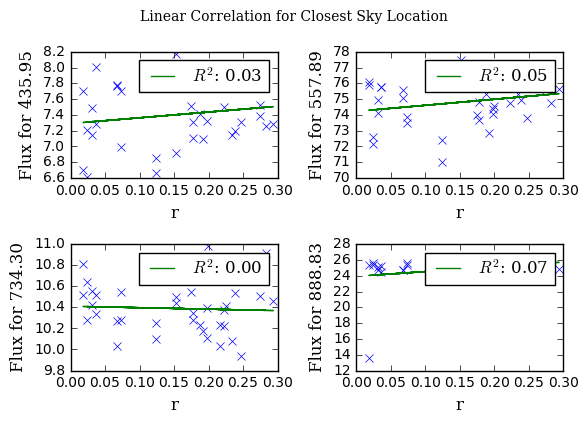

In [97]:
#For a random plate
plate = np.random.choice(np.unique(MetaDark['PLATE']),1)
image = np.random.choice(np.unique(MetaDark[MetaDark['PLATE']==plate]['IMG']),1)
plot_linear_corr('Closest Sky Location', plate, image , closest_sky_location, qa_lines)

In [29]:
def closest_detector_location(plate, image, line_w):
    data = np.load(DATA_DIR+'%d_calibrated_sky.npy' % plate)
    plate_meta = MetaDark[MetaDark['PLATE'] == plate]
    meta = plate_meta[plate_meta['IMG'] == image]
    airmass = np.unique(meta['AIRMASS'])
    
    if line_w < 630:
        my_meta = meta[meta['CAMERAS'] == b'b1']
    elif line_w > 630:
        my_meta = meta[meta['CAMERAS'] == b'r1']
    
    flux = []
    min_sep = []
    fibs = []

    for line in my_meta:
        fibs.append(line['FIB'])
    
    for line in my_meta:
        spec = line['SPECNO']
        fiber = line['FIB']
        spectrum = data[spec]
        
        flux.append(line_flux_calc(line_w, spectrum['WAVE'], spectrum['SKY']))
        seps = [np.abs(fiber-fib) for fib in fibs]
        min_sep.append(np.sort(seps)[1])   
        
    return min_sep, flux                                         

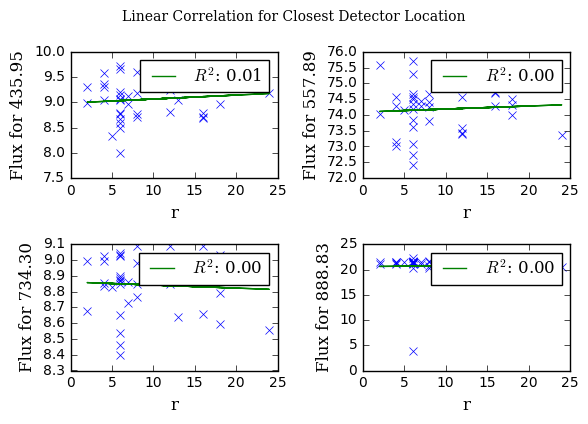

In [99]:
#For a random plate
plate = np.random.choice(np.unique(MetaDark['PLATE']),1)
image = np.random.choice(np.unique(MetaDark[MetaDark['PLATE']==plate]['IMG']),1)
plot_linear_corr('Closest Detector Location', plate, image , closest_detector_location, qa_lines)

In [6]:
np.random.choice(np.unique(MetaDark['PLATE']),50)

array([4181, 4725, 3986, 6833, 4885, 6063, 4885, 4994, 6030, 5188, 7422,
       4724, 3947, 3922, 3922, 3868, 6063, 5187, 4054, 6026, 4060, 4807,
       4973, 6039, 7027, 4778, 5190, 3975, 7032, 4975, 6039, 6037, 5190,
       6037, 6039, 6723, 4181, 6723, 4060, 6688, 4023, 4994, 7028, 7422,
       6723, 4780, 4998, 7091, 3954, 3954], dtype=int32)

### Full Model

In [28]:
import statsmodels.api as sm

In [33]:
# Create dataset
line_w = qa_lines[0]
Flux = []
A = []
for filen in os.listdir('/Users/parkerf/Desktop/sample_spframe_files/'):
    plate = filen[-23:-19]
    data = np.load('/Users/parkerf/Desktop/sample_spframe_files/'+filen)
    plate_meta = MetaDark[MetaDark['PLATE'] == int(plate)]
    for image in np.unique(MetaDark[MetaDark['PLATE'] == int(plate)]['IMG']):
        meta = plate_meta[plate_meta['IMG'] == image]
        #field_RA = np.unique(meta['RA'])
        #field_DEC = np.unique(meta['DEC'])
        #field_center = SkyCoord(ra=field_RA, dec = field_DEC, unit=u.deg, frame = 'icrs')
        
        if line_w < 630:
            my_meta = meta[meta['CAMERAS'] == b'b1']
        elif line_w > 630:
            my_meta = meta[meta['CAMERAS'] == b'r1']
            
        for line in my_meta:
            spec = line['SPECNO']
            spectrum = data[spec]
            Flux.append(line_flux_calc(line_w, spectrum['WAVE'], spectrum['SKY']))

            rr = (np.sqrt(line['XFOCAL_x']**2+line['YFOCAL_x']**2))
            fiber = line['FIB']
            #sep = SkyCoord(ra=line['FIBER_RA'], dec = line['FIBER_DEC'], unit=u.deg, frame='icrs').separation(field_center).value[0]
            
            A.append([rr, fiber])

/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in sqrt


In [ ]:
print(Flux)
Y = np.array(Flux)
X = np.stack(A)

In [39]:
X = sm.add_constant(X)

In [40]:
model = sm.OLS(Y,X)
results = model.fit()

In [41]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     8.359
Date:                Sat, 07 Oct 2017   Prob (F-statistic):           1.52e-05
Time:                        01:38:20   Log-Likelihood:                -10960.
No. Observations:                6688   AIC:                         2.193e+04
Df Residuals:                    6684   BIC:                         2.196e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          8.4257      0.058    144.730      0.000         8.312     8.540
x1            -0.0329      0.036     -0.915      0.360        -0.103     0.038
x2          7.967e-05      0.000      0.765      0.444        -0.000     0.000
x3             6.9530      7.839      0.887      0.375        -8.414    22.320
==============================================================================
Omnibus:                     1163.031   Durbin-Watson:                   0.378
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12272.595
Skew:                           0.513   Prob(JB):                         0.00
Kurtosis:                       9.557   Cond. No.                     1.77e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.77e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [42]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
prstd, iv_l, iv_u = wls_prediction_std(results)

In [43]:
params = {1:'Plate Loc',2:'Detector Loc',3:'Sky Loc'}

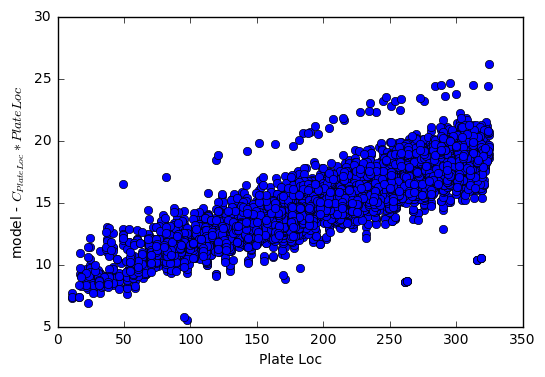

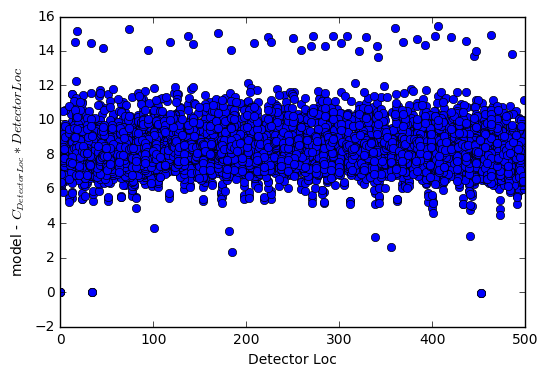

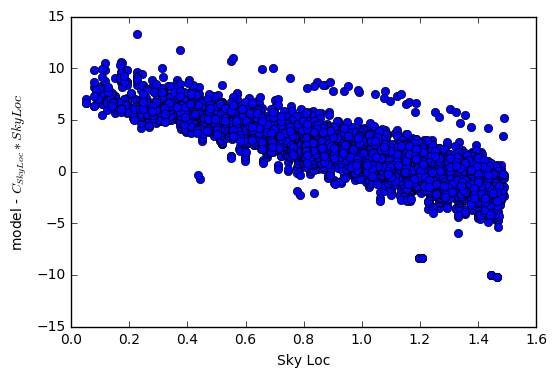

In [47]:
for i, name in params.items():
    Y_new = Y - results.params[i]*X[:,i]
    plt.figure()
    plt.plot(X[:,i],Y_new,'o')
    plt.xlabel(name)
    plt.ylabel('model - $C_{%s}*%s$'%(name,name))

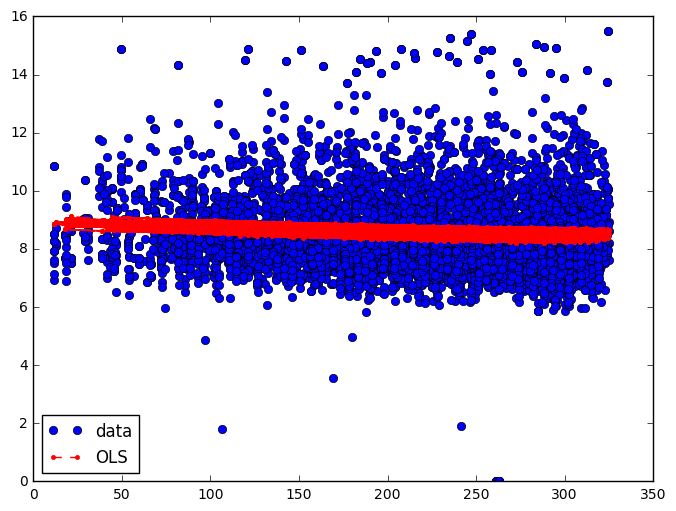

In [59]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(X[:,1],Y, 'o', label="data")
ax.plot(X[:,1],results.fittedvalues, 'r--.', label="OLS")
#ax.plot(iv_u, 'r--')
#ax.plot(iv_l, 'r--')
ax.legend(loc='best')